In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from scipy.integrate import solve_ivp
import pandas as pd

# Data Analysis

In [2]:
import matplotlib.dates as mdates

In [3]:
# Data reading and processing
df = pd.read_csv('covid_raw_data.csv')
df = df.drop(columns=['Unnamed: 4'])
df = df.rename(columns={'Date':'date', 'Positive Total':'total', 'Positive New':'new', '7-day confirmed case average':'ave'})
df['date'] = pd.to_datetime(df.date, infer_datetime_format=True)
df = df[:500]
df.head()

,date,total,new,ave
0,2020-01-29,1,1,NaN
1,2020-01-30,1,0,NaN
2,2020-01-31,1,0,NaN
3,2020-02-01,1,0,NaN
4,2020-02-02,1,0,NaN


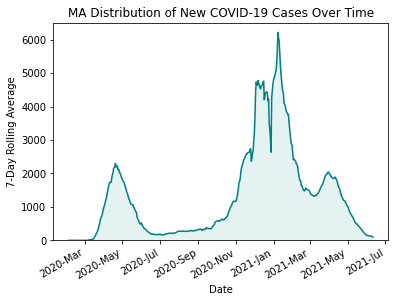

In [4]:
fig, ax = plt.subplots()
ax.plot(df.date, df.ave, color='teal')
ax.fill_between(df.date, 0, df.ave, color='teal', alpha=.1)
ax.set_ylim([0, 6500])
ax.set_ylabel('7-Day Rolling Average');
ax.set_xlabel('Date')
ax.set_title('MA Distribution of New COVID-19 Cases Over Time');

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

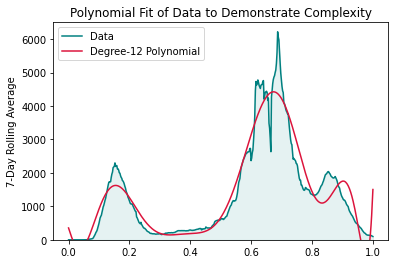

In [5]:
# Set polynomial degree
n = 12

# Create data and a Vandermonde matrix.
x = np.linspace(0, 1, len(df.new[7:]))
A = np.vander(x, n)
y = df.ave[7:]

# Solve using the least-squares function
b = np.linalg.lstsq(A, y, rcond=None)[0]

plt.plot(x, df.ave[7:], color='teal', label='Data')
plt.plot(x, A @ b, color='crimson', label='Degree-12 Polynomial')
plt.fill_between(x, 0, df.ave[7:], color='teal', alpha=.1)
plt.ylim([0, 6500]);
plt.title('Polynomial Fit of Data to Demonstrate Complexity')
plt.legend()
plt.ylabel('7-Day Rolling Average');

# SEIRS Model

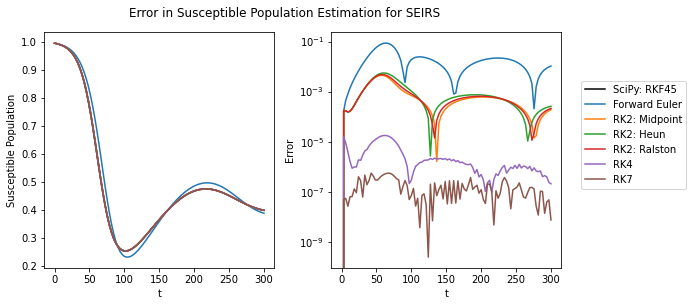

In [6]:
# initial values of population compartments
i_initial = 3/1000
r_initial = 0.00
s_initial = 1 - i_initial - r_initial
e_initial = 0.00

# Model parameters
beta = .24
xi = .01
gamma = .1
sigma = .25
delta = .04

T_final = 300
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))

# SEIR model differential equations.
def f(t, x):
    s, e, i, r = x
    dsdt = -beta * s * i/(s+e+i+r)+xi*r
    dedt = beta * s * i/(s+e+i+r) - sigma * e
    didt = sigma * e - gamma * i
    drdt =  gamma * i -xi*r
    return np.array([dsdt, dedt, didt, drdt])

t = np.linspace(0, T_final, 100)
yinit = s_initial,e_initial, i_initial, r_initial


sol = scipy.integrate.solve_ivp(f,
                                t_span=(t[0], t[-1]),
                                y0=yinit,
                                t_eval=t,
                                rtol=1e-9)
yref = sol.y[0]
ax0.plot(t, yref, label='SciPy: RKF45', c='k')

def euler(f, t, y, h):
    y = y + h * f(t, y)
    return y


def rk2_midpoint(f, t, y, h):
    y = y + h * f(t + 0.5 * h, y + 0.5 * h * f(t, y))
    return y


def rk2_heun(f, t, y, h):
    k1 = f(t, y)
    k2 = f(t + h, y + h * k1)
    y = y + 0.5 * h * (k1 + k2)
    return y


def rk2_ralston(f, t, y, h):
    k1 = f(t, y)
    k2 = f(t + 2 * h / 3, y + 2 * h / 3 * k1)
    y = y + 0.25 * h * (k1 + 3 * k2)
    return y

def rk4(f, t, y, h):
    
    alpha = [0, 0.5, 0.5, 1]
    beta = [
        [0.5],
        [0, 0.5],
        [0, 0, 1],
    ]
    gamma = [
        1. / 6,
        1. / 3,
        1. / 3,
        1. / 6,
    ]

    n = len(alpha)  # Number of stages.
    k = []  # Intermediate evaluations.
    k.append(f(t + alpha[0], y))  # First stage.
    # Second and subsequent stages.
    for i in range(1, n):
        tt = t + alpha[i]
        yy = y
        for j in range(i):
            yy = yy + h * beta[i - 1][j] * k[j]
        k.append(f(tt, yy))
    yy = y
    for j in range(n):
        yy = yy + h * gamma[j] * k[j]
    return yy

def rk7(f, t, y, h):
    
    alpha = [
        0, 2. / 27, 1. / 9, 1. / 6, 5. / 12, 1. / 2, 5. / 6, 1. / 6, 2. / 3,
        1. / 3, 1., 0, 1
    ]
    beta = [
        [2. / 27],
        [1. / 36, 1. / 12],
        [1. / 24, 0, 1. / 8],
        [5. / 12, 0, -25. / 16, 25. / 16],
        [1. / 20, 0, 0, 1. / 4, 1. / 5],
        [-25. / 108, 0, 0, 125. / 108, -65. / 27, 125. / 54],
        [31. / 300, 0, 0, 0, 61. / 225, -2. / 9, 13. / 900],
        [2., 0, 0, -53. / 6, 704. / 45, -107. / 9, 67. / 90, 3],
        [
            -91. / 108, 0, 0, 23. / 108, -976. / 135, 311. / 54, -19. / 60,
            17. / 6, -1. / 12
        ],
        [
            2383. / 4100, 0, 0, -341. / 164, 4496. / 1025, -301. / 82,
            2133. / 4100, 45. / 82, 45. / 164, 18. / 41
        ],
        [
            3. / 205, 0, 0, 0, 0, -6. / 41, -3. / 205, -3. / 41, 3. / 41,
            6. / 41, 0
        ],
        [
            -1777. / 4100, 0, 0, -341. / 164, 4496. / 1025, -289. / 82,
            2193. / 4100, 51. / 82, 33. / 164, 12. / 41, 0, 1.
        ],
    ]
    gamma = [
        41. / 840, 0, 0, 0, 0, 34. / 105, 9. / 35, 9. / 35, 9. / 280, 9. / 280,
        41. / 840, 0, 0
    ]

    n = len(alpha)  # Number of stages.
    k = []  # Intermediate evaluations.
    k.append(f(t + alpha[0], y))  # First stage.
    # Second and subsequent stages.
    for i in range(1, n):
        tt = t + alpha[i]
        yy = y
        for j in range(i):
            yy = yy + h * beta[i - 1][j] * k[j]
        k.append(f(tt, yy))
    yy = y
    for j in range(n):
        yy = yy + h * gamma[j] * k[j]
    return yy



for method, lbl in [
    (euler, 'Forward Euler'),
    (rk2_midpoint, 'RK2: Midpoint'),
    (rk2_heun, 'RK2: Heun'),
    (rk2_ralston, 'RK2: Ralston'),
    (rk4, 'RK4'),
    (rk7, 'RK7')
]:
    y = np.zeros((len(t), 4))
    y[0] = yinit
    for k in range(len(t) - 1):
        y[k + 1] = method(f, t[k], y[k], t[k + 1] - t[k])
    l, = ax0.plot(t, y[:, 0], label=lbl)
    ax1.plot(t, abs(y[:, 0] - yref), c=l.get_color())

fig.legend(bbox_to_anchor=(1.2, 0.8))
ax0.set_xlabel('t')
ax0.set_ylabel('Susceptible Population')
ax1.set_xlabel('t')
ax1.set_ylabel('Error')
ax1.set_yscale('log')
plt.tight_layout()
plt.suptitle('Error in Susceptible Population Estimation for SEIRS', y=1.05);

# Quarantine/Social Distancing Implementation

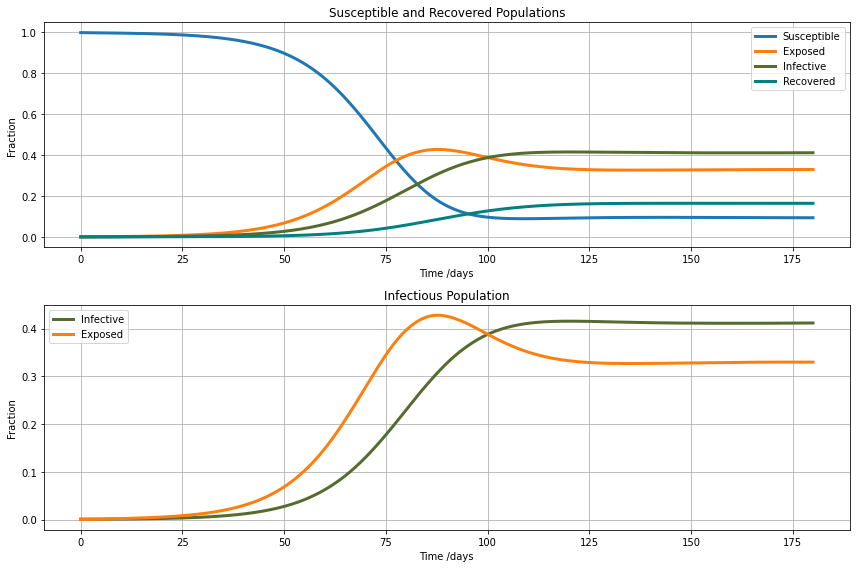

In [8]:

# constant quarantine

# strong initial quarantine
beta = lambda t: .12*np.log(np.sqrt(t)+2)+.1



R0 = 2.4
t_infective = 5 + 3
t_incubation = 5
# initial number of infected and recovered individuals
i_initial = 1/1000
r_initial = 0.00
s_initial = 1 - i_initial - r_initial
e_initial = 0.00
xi = .1
gamma = .04
sigma = .05
delta = .04


# SEIR model differential equations.
def deriv(t, x, beta, sigma, gamma, xi):
    s, e, i, r = x
    dsdt = -beta(t) * s * i/(s+e+i+r)+xi*r
    dedt = beta(t) * s * i/(s+e+i+r) - sigma * e
    didt = sigma * e - gamma * i
    drdt =  gamma * i -xi*r
    return [dsdt, dedt, didt, drdt]

t = np.linspace(0, 180, 2000)
x_initial = s_initial,e_initial, i_initial, r_initial

# Note we use Runge Kutta 45
soln = solve_ivp(deriv, (0,180),x_initial, t_eval=t, args=(beta, sigma, gamma, xi))
s,e, i, r = soln.y[0,:],soln.y[1,:],soln.y[2,:],soln.y[3,:]

def plotdata(t, s, e, i):
    # plot the data
    fig, ax = plt.subplots(2,1, figsize=(12,8))
    
    
    ax[0].plot(t, s, lw=3, label='Susceptible', color='tab:blue')
    ax[0].plot(t, e, lw=3, label='Exposed', color='tab:orange')
    ax[0].plot(t, i, lw=3, label='Infective', color='darkolivegreen')
    ax[0].plot(t, r, lw=3, label='Recovered', color='teal')
    ax[0].set_title('Susceptible and Recovered Populations')
    ax[0].set_xlabel('Time /days')
    ax[0].set_ylabel('Fraction')

    ax[1].plot(t, i, lw=3, label='Infective', color='darkolivegreen')
    ax[1].set_title('Infectious Population')
    ax[1].plot(t, e, lw=3, label='Exposed', color='tab:orange')
    ax[1].set_xlabel('Time /days')
    ax[1].set_ylabel('Fraction')

    for a in ax: 
        a.grid(True)
        a.legend()

    plt.tight_layout()
    
plotdata(t, s, e, i)

# Vaccination Model

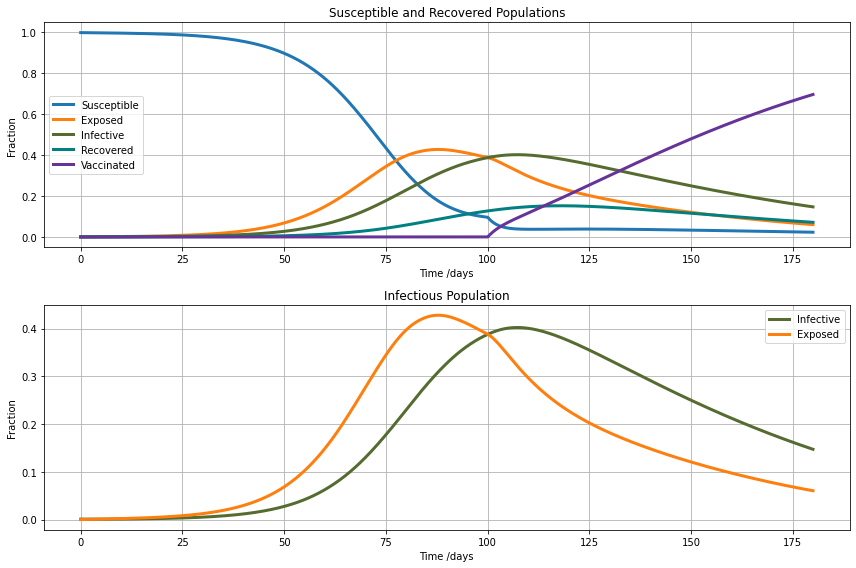

In [ ]:
# Define scaling vaccination rollout after start time 100
def vac(t):
  return 0 if t < 100 else 0.05*np.log(t)


# Strong initial quarantine
beta = lambda t: .12*np.log(np.sqrt(t)+2)+.1



# Initial number of infected and recovered individuals
i_initial = 1/1000
r_initial = 0.00
s_initial = 1 - i_initial
e_initial = 0.00
v_initial = 0.00
xi = .1
gamma = .04
sigma = .05
delta = .04
#vaccine failure rate
rho = 0.0001

# SEIR model differential equations.
def deriv(t, x, beta, vac, sigma, gamma, xi, rho):
    s, e, i, r, v = x
    dsdt = -beta(t) * s * i/(s+e+i+r+v)+xi*r-vac(t)*s
    dedt = beta(t) * s * i/(s+e+i+r+v) - sigma * e
    didt = sigma * e - gamma * i 
    drdt =  gamma * i -xi*r
    dvdt = vac(t)*s-rho*v*i
    return [dsdt, dedt, didt, drdt, dvdt]

t = np.linspace(0, 180, 2000)
x_initial = s_initial,e_initial, i_initial, r_initial, v_initial

# Note we use Runge Kutta 45
soln = solve_ivp(deriv, (0,180), x_initial, t_eval=t, args=(beta, vac, sigma, gamma, xi, rho))
s,e, i, r,v = soln.y[0,:],soln.y[1,:],soln.y[2,:],soln.y[3,:],soln.y[4,:]

def plotdata(t, s, e, i):
    # plot the data
    fig, ax = plt.subplots(2,1, figsize=(12,8))
    
    # these are our color choices
    ax[0].plot(t, s, lw=3, label='Susceptible', color="tab:blue")
    ax[0].plot(t, e, lw=3, label='Exposed', color="tab:orange")
    ax[0].plot(t, i, lw=3, label='Infective', color="darkolivegreen")
    ax[0].plot(t, r, lw=3, label='Recovered', color="teal")
    ax[0].plot(t, v, lw=3, label='Vaccinated', color="rebeccapurple")
    ax[0].set_title('Susceptible and Recovered Populations')
    ax[0].set_xlabel('Time /days')
    ax[0].set_ylabel('Fraction')

    ax[1].plot(t, i, lw=3, label='Infective', color="darkolivegreen")
    ax[1].set_title('Infectious Population')
    ax[1].plot(t, e, lw=3, label='Exposed', color="tab:orange")
    ax[1].set_xlabel('Time /days')
    ax[1].set_ylabel('Fraction')

    for a in ax: 
        a.grid(True)
        a.legend()

    plt.tight_layout()
    
plotdata(t, s, e, i)

# Vaccine Efficacy Comparison

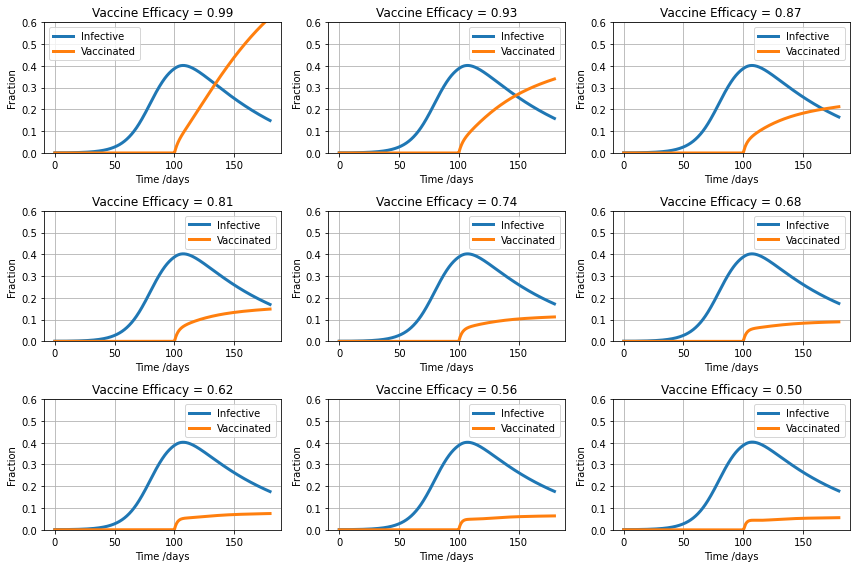

In [ ]:
# plot different vaccine efficacies
def vac(t):
  return 0 if t < 100 else 0.05*np.log(t)


# strong initial quarantine
beta = lambda t: .12*np.log(np.sqrt(t)+2)+.1



# initial number of infected and recovered individuals
i_initial = 1/1000
r_initial = 0.00
s_initial = 1 - i_initial
e_initial = 0.00
v_initial = 0.00
xi = .1
gamma = .04
sigma = .05
delta = .04
#vaccine failure rate
rho = 0.0001

# SEIR model differential equations.
def deriv(t, x, beta, vac, sigma, gamma, xi, rho):
    s, e, i, r, v = x
    dsdt = -beta(t) * s * i/(s+e+i+r+v)+xi*r-vac(t)*s
    dedt = beta(t) * s * i/(s+e+i+r+v) - sigma * e
    didt = sigma * e - gamma * i 
    drdt =  gamma * i -xi*r
    dvdt = vac(t)*s-rho*v*i
    return [dsdt, dedt, didt, drdt, dvdt]

t = np.linspace(0, 180, 2000)
x_initial = s_initial,e_initial, i_initial, r_initial, v_initial

# Note we use Runge Kutta 45



fig, ax = plt.subplots(3,3, figsize=(12,8))
rhos = np.linspace(0.01, 0.5, 9)
for j in range(9):
  rho = rhos[j]
  soln = solve_ivp(deriv, (0,180), x_initial, t_eval=t, args=(beta, vac, sigma, gamma, xi, rho))
  s,e, i, r,v = soln.y[0,:],soln.y[1,:],soln.y[2,:],soln.y[3,:],soln.y[4,:]
  ax[j//3][j%3].plot(t, i, lw=3, label='Infective')
  ax[j//3][j%3].plot(t, v, lw=3, label='Vaccinated')
  ax[j//3][j%3].set_title(f'Vaccine Efficacy = {1-rho:.2f}')
  ax[j//3][j%3].set_xlabel('Time /days')
  ax[j//3][j%3].set_ylabel('Fraction')
  ax[j//3][j%3].grid(True)
  ax[j//3][j%3].legend()
  ax[j//3][j%3].set_ylim(0,.6)


plt.tight_layout()

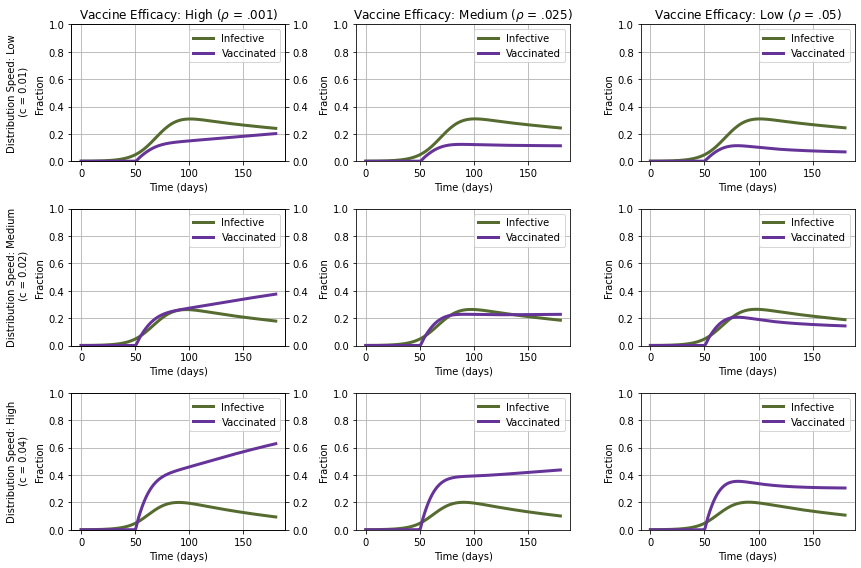

In [ ]:
# Including vitals with variable vaccination
lam = 0.001
delta = 0.001
mu = 0.005
rho = 0.0001
beta = lambda t: 0.4
v1 = lambda t: 0 if t<50 else 0.01# * np.log(t)
v2 = lambda t: 0 if t<50 else 0.02# * np.log(t)
v3 = lambda t: 0 if t<50 else 0.04# * np.log(t)
vax = [v1,v2,v3]

# vax = np.linspace(0.001, 0.01, 3)
# SEIR model differential equations.
def deriv(t, x, beta, vac, sigma, gamma, xi, rho):
    s, e, i, r, v = x
    dsdt = -beta(t) * s * i/(s+e+i+r+v)+xi*r-vac(t)*s+lam*(s+e+i+r+v)-delta*s
    dedt = beta(t) * s * i/(s+e+i+r+v) - sigma * e-delta*e
    didt = sigma * e - gamma * i -mu*i-delta*i
    drdt =  gamma * i -xi*r-delta*r
    dvdt = vac(t)*s-rho*v*i-delta*v
    return [dsdt, dedt, didt, drdt, dvdt]

fig, ax = plt.subplots(3,3, figsize=(12,8))
rhos = np.linspace(0.001, 0.05, 3)
for j in range(9):
  vac = vax[j//3]
  rho = rhos[j%3]
  soln = solve_ivp(deriv, (0,180), x_initial, t_eval=t, args=(beta, vac, sigma, gamma, xi, rho))
  s,e, i, r,v = soln.y[0,:],soln.y[1,:],soln.y[2,:],soln.y[3,:],soln.y[4,:]
  ax[j//3][j%3].plot(t, i, lw=3, label='Infective', color="darkolivegreen")
  ax[j//3][j%3].plot(t, v, lw=3, label='Vaccinated', color="rebeccapurple")
  ax[j//3][j%3].set_xlabel('Time (days)')
  ax[j//3][j%3].set_ylabel('Fraction')
  ax[j//3][j%3].grid(True)
  ax[j//3][j%3].legend()
  ax[j//3][j%3].set_ylim(0,1)

ax[0][0].set_title(rf'Vaccine Efficacy: High ($\rho$ = .001)')
ax[0][1].set_title(rf'Vaccine Efficacy: Medium ($\rho$ = .025)')
ax[0][2].set_title(rf'Vaccine Efficacy: Low ($\rho$ = .05)')
ax2 = ax[0][0].twinx()
ax2.yaxis.set_label_coords(-.3, .5)
ax2.set_ylabel(f'Distribution Speed: Low\n (c = 0.01)')
ax2 = ax[1][0].twinx()
ax2.yaxis.set_label_coords(-.3, .5)
ax2.set_ylabel(f'Distribution Speed: Medium\n (c = 0.02)')
ax2 = ax[2][0].twinx()
ax2.yaxis.set_label_coords(-.3, .5)
ax2.set_ylabel(f'Distribution Speed: High\n (c = 0.04)')

plt.tight_layout()

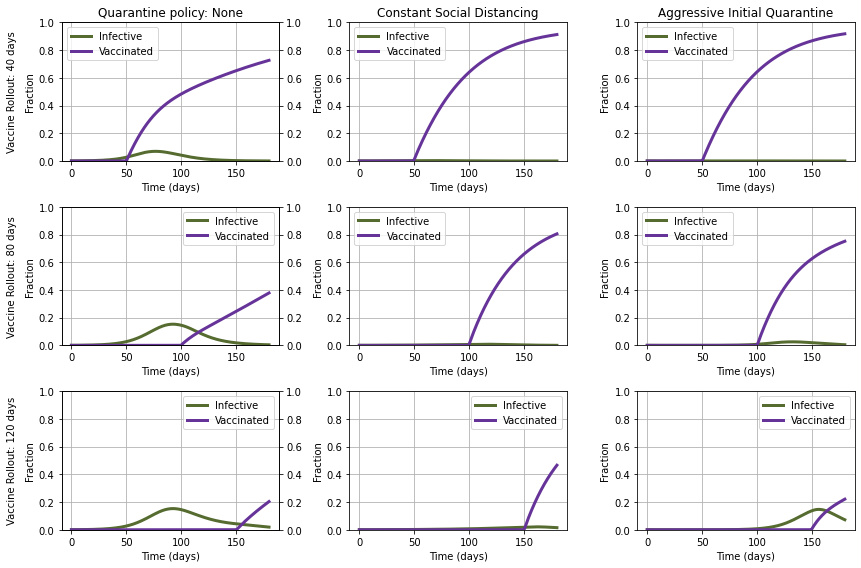

In [ ]:
# Constant social distancing
b1 = lambda t: 0.24
b2 = lambda t: .24*.6
b3 = lambda t: 0.24*.3 if t< 50 else 0.24

betas = [b1,b2,b3]

lam = 0.001
delta = 0.001
sigma = 0.25
mu = 0.005
gamma = 0.1
xi = 0.01
rho = 0.0001

v1 = lambda t: 0 if t<50 else 0.005*np.log(t)
v2 = lambda t: 0 if t<100 else 0.005*np.log(t)
v3 = lambda t: 0 if t<150 else 0.005*np.log(t)
vax = [v1,v2,v3]
# SEIR model differential equations.
def deriv(t, x, beta, vac, sigma, gamma, xi, rho):
    s, e, i, r, v = x
    dsdt = -beta(t) * s * i/(s+e+i+r+v)+xi*r-vac(t)*s+lam*(s+e+i+r+v)-delta*s
    dedt = beta(t) * s * i/(s+e+i+r+v) - sigma * e-delta*e
    didt = sigma * e - gamma * i -mu*i-delta*i
    drdt =  gamma * i -xi*r-delta*r
    dvdt = vac(t)*s-rho*v*i-delta*v
    return [dsdt, dedt, didt, drdt, dvdt]

fig, ax = plt.subplots(3,3, figsize=(12,8))
rhos = np.linspace(0.01, 0.5, 3)
for j in range(9):
  vac = vax[j//3]
  beta = betas[j%3]
  soln = solve_ivp(deriv, (0,180), x_initial, t_eval=t, args=(beta, vac, sigma, gamma, xi, rho))
  s,e, i, r,v = soln.y[0,:],soln.y[1,:],soln.y[2,:],soln.y[3,:],soln.y[4,:]
  ax[j//3][j%3].plot(t, i, lw=3, label='Infective', color="darkolivegreen")
  ax[j//3][j%3].plot(t, v, lw=3, label='Vaccinated', color="rebeccapurple")
  ax[j//3][j%3].set_xlabel('Time (days)')
  ax[j//3][j%3].set_ylabel('Fraction')
  ax[j//3][j%3].grid(True)
  ax[j//3][j%3].legend()
  ax[j//3][j%3].set_ylim(0,1)

ax[0][0].set_title(f'Quarantine policy: None')
ax[0][1].set_title(f'Constant Social Distancing')
ax[0][2].set_title(f'Aggressive Initial Quarantine')

ax2 = ax[0][0].twinx()
ax2.yaxis.set_label_coords(-.25, .5)
ax2.set_ylabel(f'Vaccine Rollout: 40 days')
ax2 = ax[1][0].twinx()
ax2.yaxis.set_label_coords(-.25, .5)
ax2.set_ylabel(f'Vaccine Rollout: 80 days')
ax2 = ax[2][0].twinx()
ax2.yaxis.set_label_coords(-.25, .5)
ax2.set_ylabel(f'Vaccine Rollout: 120 days')
plt.tight_layout()

# Optimization:

In [ ]:
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
from scipy.integrate import solve_ivp

In [ ]:
# 1/.95 * (1-rho) * .01 * start_date + 200 * rollout - 3 = 0

def beta(t):
    return .24

sigma = .25
gamma = .1
xi = .01

def vac(t, start_date, rollout):
    if t < start_date:
        return 0
    else:
        return rollout*np.log(t)

def deriv(t, x, rho, start_date, rollout):
    s, e, i, r, v = x
    dsdt = -beta(t) * s * i/(s+e+i+r+v)+xi*r-vac(t, start_date, rollout)*s
    dedt = beta(t) * s * i/(s+e+i+r+v) - sigma * e
    didt = sigma * e - gamma * i
    drdt = gamma * i - xi*r
    dvdt = vac(t, start_date, rollout)*s-rho*v*i
    return [dsdt, dedt, didt, drdt, dvdt]

def sum_infected_vac(params):
    rho, start_date, rollout = params
    x0 = [994, 3, 3, 0, 0]
    sol = solve_ivp(deriv, t_span=[0, 300], y0=x0, args=(rho, start_date, rollout))
    return sum(sol.y[2])

def max_infected_vac(params):
    rho, start_date, rollout = params
    x0 = [994, 3, 3, 0, 0]
    sol = solve_ivp(deriv, t_span=[0, 300], y0=x0, args=(rho, start_date, rollout))
    return max(sol.y[2])

In [ ]:
def fun_vac(params):
    rho, start_date, rollout = params
    return [1/.95*(1-rho)+.1*np.sqrt(start_date)+200*rollout-3]


con_vac = NonlinearConstraint(fun_vac, lb=0, ub=0)
a = minimize(sum_infected_vac, [.05, 100, .005], method='trust-constr', bounds=[[0, 1], [1, 300], [0, 1]], constraints=[con_vac])
a.x

array([1.70483382e-03, 1.00833885e+02, 4.72501107e-03])

In [ ]:
def fun_vac(params):
    rho, start_date, rollout = params
    return [1/.95*(1-rho)+0.01*(start_date)+200*rollout-3]


con_vac = NonlinearConstraint(fun_vac, lb=0, ub=0)

a = minimize(max_infected_vac, [.05, 100, .005], method='trust-constr', bounds=[[0, 1], [1, 300], [0, 1]], constraints=[con_vac])
a.x

array([4.20982868e-01, 1.00004417e+02, 6.95232054e-03])

### Optimization for Minimizing Total Number of Infections

max val 0.07110389564734965
total infected:  47.08670713380151


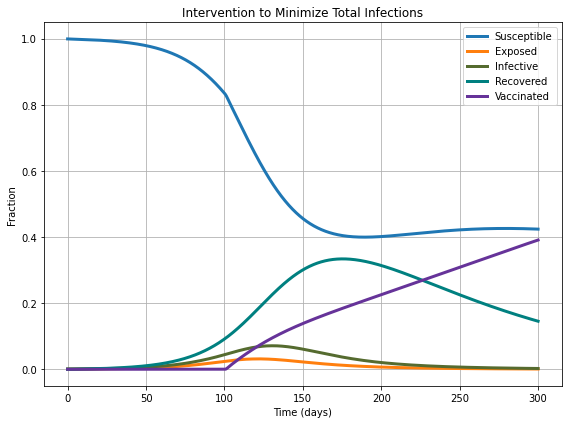

In [ ]:
from matplotlib.axes import Axes
# Optimized Model for Total Infections

# strong initial quarantine
beta = lambda t: .18

R0 = 2.4
t_infective = 5 + 3
t_incubation = 5
# initial number of infected and recovered individuals
i_initial = 1/1000
r_initial = 0.00
s_initial = 1 - i_initial
e_initial = 0.00
v_initial = 0.00
xi = .01
gamma = .1
sigma = .25
delta = .001
#vaccine failure rate
rho = 0.0017
def vac(t):
  if t<101:
    return 0
  else:
    return 0.0047

# SEIR model differential equations.
def deriv(t, x, beta, vac, sigma, gamma, xi, rho):
    s, e, i, r, v = x
    dsdt = -beta(t) * s * i/(s+e+i+r+v)+xi*r-vac(t)*s+lam*(s+e+i+r+v)-delta*s
    dedt = beta(t) * s * i/(s+e+i+r+v) - sigma * e-delta*e
    didt = sigma * e - gamma * i -mu*i-delta*i
    drdt =  gamma * i -xi*r-delta*r
    dvdt = vac(t)*s-rho*v*i-delta*v
    return [dsdt, dedt, didt, drdt, dvdt]

t = np.linspace(0, 300, 2000)
x_initial = s_initial,e_initial, i_initial, r_initial, v_initial

# Note we use Runge Kutta 45
soln = solve_ivp(deriv, (0,300), x_initial, t_eval=t, args=(beta, vac, sigma, gamma, xi, rho))
s,e, i, r,v = soln.y[0,:],soln.y[1,:],soln.y[2,:],soln.y[3,:],soln.y[4,:]

def plotdata(t, s, e, i):
    # plot the data
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    
    # these are our color choices
    ax.plot(t, s, lw=3, label='Susceptible', color="tab:blue")
    ax.plot(t, e, lw=3, label='Exposed', color="tab:orange")
    ax.plot(t, i, lw=3, label='Infective', color="darkolivegreen")
    ax.plot(t, r, lw=3, label='Recovered', color="teal")
    ax.plot(t, v, lw=3, label='Vaccinated', color="rebeccapurple")
    ax.set_title('Intervention to Minimize Total Infections')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Fraction')
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    
plotdata(t, s, e, i)
max_i = max(i)
print("max val", max(i))
print("total infected: ", sum(i))
tot = sum(i)

### Optimization for Minimizing Total Number of Infected at Any Single Time

max val:  0.0670468219123757
total infected:  41.14703242453492
0.12614334428586013
-0.060511052116328345


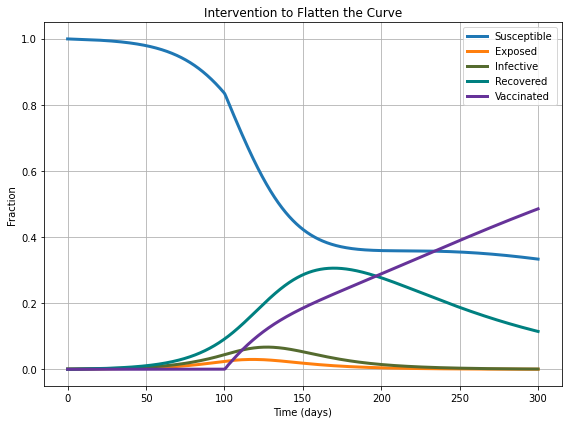

In [ ]:
beta = lambda t: .18

R0 = 2.4
t_infective = 5 + 3
t_incubation = 5
# initial number of infected and recovered individuals
i_initial = 1/1000
r_initial = 0.00
s_initial = 1 - i_initial
e_initial = 0.00
v_initial = 0.00
xi = .01
gamma = .1
sigma = .25
delta = .001
#vaccine failure rate
rho = 0.042
def vac(t):
  if t<100:
    return 0
  else:
    return 0.0069

# SEIR model differential equations.
def deriv(t, x, beta, vac, sigma, gamma, xi, rho):
    s, e, i, r, v = x
    dsdt = -beta(t) * s * i/(s+e+i+r+v)+xi*r-vac(t)*s+lam*(s+e+i+r+v)-delta*s
    dedt = beta(t) * s * i/(s+e+i+r+v) - sigma * e-delta*e
    didt = sigma * e - gamma * i -mu*i-delta*i
    drdt =  gamma * i -xi*r-delta*r
    dvdt = vac(t)*s-rho*v*i-delta*v
    return [dsdt, dedt, didt, drdt, dvdt]

t = np.linspace(0, 300, 2000)
x_initial = s_initial,e_initial, i_initial, r_initial, v_initial

# Note we use Runge Kutta 45
soln = solve_ivp(deriv, (0,300), x_initial, t_eval=t, args=(beta, vac, sigma, gamma, xi, rho))
s,e, i, r,v = soln.y[0,:],soln.y[1,:],soln.y[2,:],soln.y[3,:],soln.y[4,:]

def plotdata(t, s, e, i):
    # plot the data
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    
    # these are our color choices
    ax.plot(t, s, lw=3, label='Susceptible', color="tab:blue")
    ax.plot(t, e, lw=3, label='Exposed', color="tab:orange")
    ax.plot(t, i, lw=3, label='Infective', color="darkolivegreen")
    ax.plot(t, r, lw=3, label='Recovered', color="teal")
    ax.plot(t, v, lw=3, label='Vaccinated', color="rebeccapurple")
    ax.set_title('Intervention to Flatten the Curve')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Fraction')
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    
plotdata(t, s, e, i)
print("max val: ", max(i))
print("total infected: ", sum(i))
print((tot-sum(i))/tot)
print((max(i)-max_i)/max(i))

# Stochastic SEIRS

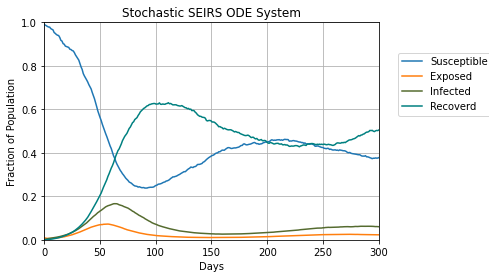

In [9]:
beta = .24
xi = .01
gamma = .1
sigma = .25

N = 1000

# SEIR model differential equations.
def f(t, x):
    s, e, i, r = x
    dsdt = -beta * s * i/(s+e+i+r)+xi*r
    dedt = beta * s * i/(s+e+i+r) - sigma * e
    didt = sigma * e - gamma * i
    drdt =  gamma * i -xi*r
    return np.array([dsdt, dedt, didt, drdt])

def d_wiener(y, pert=0.005):
    n = len(y)
    noise = np.zeros(n)
    
    for i in range(n):
        noise[i] = pert * y[i] * np.random.normal(loc=0, scale=1)

    return noise
  
def rk4(f, t, y, h):
    
    alpha = [0, 0.5, 0.5, 1]
    beta = [
        [0.5],
        [0, 0.5],
        [0, 0, 1],
    ]
    gamma = [
        1. / 6,
        1. / 3,
        1. / 3,
        1. / 6,
    ]

    n = len(alpha)  # Number of stages.
    k = []  # Intermediate evaluations.
    k.append(f(t + alpha[0], y))  # First stage.
    # Second and subsequent stages.
    for i in range(1, n):
        tt = t + alpha[i]
        yy = y
        for j in range(i):
            yy = yy + h * beta[i - 1][j] * k[j]
        k.append(f(tt, yy))
    yy = y
    for j in range(n):
        yy = yy + h * gamma[j] * k[j]
    return yy + d_wiener(y)



# Time points of interest.
t = np.linspace(0, 300, 300)

# Initial conditions, populations of susceptible, exposed, infected, and recovered.
yinit = [990, 10, 0, 0]

fig, ax = plt.subplots(1, 1)

# Scipy.
sol = scipy.integrate.solve_ivp(f,
                                t_span=(t[0], t[-1]),
                                y0=yinit,
                                t_eval=t,
                                rtol=1e-9)

y = np.zeros((len(t), 4))
y[0] = yinit
for k in range(len(t) - 1):
    y[k + 1] = rk4(f, t[k], y[k], t[k + 1] - t[k])
l, = ax.plot(t, y[:, 0]/N, label='Susceptible', color='tab:blue')
ax.plot(t, y[:, 1]/N, label='Exposed', color='tab:orange')
ax.plot(t, y[:, 2]/N, label='Infected', color='darkolivegreen')
ax.plot(t, y[:, 3]/N, label='Recoverd', color='teal')

fig.legend(bbox_to_anchor=(1.15, .8))
ax.set_xlabel('Days')
ax.set_ylabel('Fraction of Population')
ax.set_title('Stochastic SEIRS ODE System')
ax.set_xlim([0, 300])
ax.set_ylim([0, 1])


ax.grid(':')

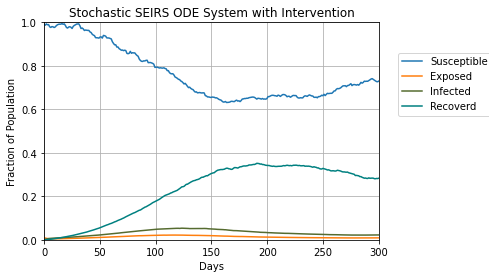

In [10]:
beta = .24*.6
xi = .01
gamma = .1
sigma = .25

N = 1000

# SEIR model differential equations.
def f(t, x):
    s, e, i, r = x
    dsdt = -beta * s * i/(s+e+i+r)+xi*r
    dedt = beta * s * i/(s+e+i+r) - sigma * e
    didt = sigma * e - gamma * i
    drdt =  gamma * i -xi*r
    return np.array([dsdt, dedt, didt, drdt])

def d_wiener(y, pert=0.005):
    n = len(y)
    noise = np.zeros(n)
    
    for i in range(n):
        noise[i] = pert * y[i] * np.random.normal(loc=0, scale=1)

    return noise
  
def rk4(f, t, y, h):
    
    alpha = [0, 0.5, 0.5, 1]
    beta = [
        [0.5],
        [0, 0.5],
        [0, 0, 1],
    ]
    gamma = [
        1. / 6,
        1. / 3,
        1. / 3,
        1. / 6,
    ]

    n = len(alpha)  # Number of stages.
    k = []  # Intermediate evaluations.
    k.append(f(t + alpha[0], y))  # First stage.
    # Second and subsequent stages.
    for i in range(1, n):
        tt = t + alpha[i]
        yy = y
        for j in range(i):
            yy = yy + h * beta[i - 1][j] * k[j]
        k.append(f(tt, yy))
    yy = y
    for j in range(n):
        yy = yy + h * gamma[j] * k[j]
    return yy + d_wiener(y)



# Time points of interest.
t = np.linspace(0, 300, 300)

# Initial conditions, populations of susceptible, exposed, infected, and recovered.
yinit = [990, 10, 0, 0]

fig, ax = plt.subplots(1, 1)

# Scipy.
sol = scipy.integrate.solve_ivp(f,
                                t_span=(t[0], t[-1]),
                                y0=yinit,
                                t_eval=t,
                                rtol=1e-9)

y = np.zeros((len(t), 4))
y[0] = yinit
for k in range(len(t) - 1):
    y[k + 1] = rk4(f, t[k], y[k], t[k + 1] - t[k])
l, = ax.plot(t, y[:, 0]/N, label='Susceptible', color='tab:blue')
ax.plot(t, y[:, 1]/N, label='Exposed', color='tab:orange')
ax.plot(t, y[:, 2]/N, label='Infected', color='darkolivegreen')
ax.plot(t, y[:, 3]/N, label='Recoverd', color='teal')

fig.legend(bbox_to_anchor=(1.15, .8))
ax.set_xlabel('Days')
ax.set_ylabel('Fraction of Population')
ax.set_title('Stochastic SEIRS ODE System with Intervention')
ax.set_xlim([0, 300])
ax.set_ylim([0, 1])


ax.grid(':')